In [1]:
import os
from tqdm import tqdm
import numpy as np
from pathlib import Path
import argparse
import logging
import torch
from torch.utils.data import DataLoader
#import wandb
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (Trainer, TrainingArguments, DataCollatorWithPadding,
                          AutoTokenizer, AutoModelForSequenceClassification)

In [23]:
model_name_or_path = "microsoft/mpnet-base"
dataset_path = '../bin/multirc_dataset.hf'
output_dir = 'results/hp-tuning'
model_max_length = 512
eval_steps = 1000
eval_accumulation_steps = 2
save_total_limit = 4
batch_size = 32
num_epochs = 8
learning_rate = 3e-05
seed = 42
metric = 'accuracy'
entity = 'ai-aloe'
project_name = 'short answer scoring'

id2label = {0: "incorrect_answer", 1: "correct_answer"}
label2id = {"incorrect_answer": 0, "correct_answer": 1}

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    max_length=model_max_length,
    )

def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path,
                                                               num_labels=2,
                                                               id2label=id2label,
                                                               label2id=label2id)
    return model

In [24]:
def preprocess_function(example):
    return tokenizer(example["text"], padding=True, truncation=True)
    
ds = DatasetDict.load_from_disk(dataset_path)
ds = ds.map(preprocess_function, batched=False)

Map:   0%|          | 0/4080 [00:00<?, ? examples/s]

In [25]:
ds

DatasetDict({
    train: Dataset({
        features: ['index', 'text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 19170
    })
    valid: Dataset({
        features: ['index', 'text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 4080
    })
    test: Dataset({
        features: ['index', 'text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 3962
    })
})

In [26]:
import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [27]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='max_length')

In [28]:
import os
os.environ['WANDB_DISABLED'] = 'true'

trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir = f'./results/mpnet_checkpoints',
    optim = 'adamw_torch',
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    learning_rate = learning_rate,
    logging_dir = f'./logs/content',
    save_total_limit = 10,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    evaluation_strategy = "epoch",
    save_strategy = "epoch", 
    greater_is_better = True,
    seed=seed,
    log_level = 'error',  
    disable_tqdm = False, 
) 

    # Call the Trainer
trainer = Trainer(
    model_init = model_init,
    args = training_args,
    data_collator=data_collator,
    train_dataset = ds['train'],
    eval_dataset = ds['valid'],
    compute_metrics = compute_metrics
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 47.54 GiB total capacity; 21.02 GiB already allocated; 201.25 MiB free; 21.39 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [10]:
import time

start_time = time.time()
preds, labels, metrics= trainer.predict(ds['test'])
predictions = np.argmax(preds, axis=1)
end_time = time.time()
print(end_time-start_time)

61.091878175735474


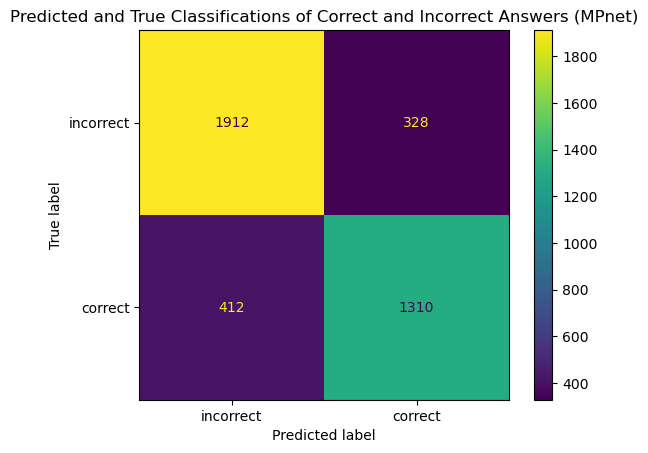

In [11]:
from sklearn import metrics
from matplotlib import pyplot as plt

confusion_matrix = metrics.confusion_matrix(labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['incorrect', 'correct'])

cm_display.plot()
plt.title('Predicted and True Classifications of Correct and Incorrect Answers (MPnet)')
plt.show()

In [12]:
print(metrics.classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      2240
           1       0.80      0.76      0.78      1722

    accuracy                           0.81      3962
   macro avg       0.81      0.81      0.81      3962
weighted avg       0.81      0.81      0.81      3962



In [10]:
trainer.save_model("../bin/mpnet_classifier")

In [16]:
import sklearn
sklearn.metrics.cohen_kappa_score(labels, predictions)

0.8378378378378378

In [14]:
import torch
import gc
from time import perf_counter
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from transformers import AutoModelForSequenceClassification
preds = []
times = []
model = AutoModelForSequenceClassification.from_pretrained("../bin/mpnet_multimc_classifier").to(device)
for text in ds['test']['text']:
    start_time = perf_counter()
    inputs = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    preds.append(model.config.id2label[predicted_class_id])
    times.append(perf_counter()-start_time)


cuda


In [21]:
df = ds['test'].to_pandas()
df['preds']=preds
df['times']=times
df.to_csv('mpnet-results.csv')

In [23]:
labels = []
for x in ds['test']['labels']:
    if x == 1:
        labels.append('correct_answer' )
    else: 
        labels.append('incorrect_answer') 

from sklearn import metrics
from matplotlib import pyplot as plt

print(metrics.classification_report(labels, preds))

                  precision    recall  f1-score   support

  correct_answer       0.80      0.76      0.78      1722
incorrect_answer       0.82      0.85      0.84      2240

        accuracy                           0.81      3962
       macro avg       0.81      0.81      0.81      3962
    weighted avg       0.81      0.81      0.81      3962



In [27]:
from huggingface_hub import notebook_login
notebook_login()


In [29]:
model.push_to_hub("short-answer-classification")
tokenizer.push_to_hub("short-answer-classification")

CommitInfo(commit_url='https://huggingface.co/tiedaar/short-answer-classification/commit/30da339a79dd1334063ce2f5ba64d6df1d676055', commit_message='Upload tokenizer', commit_description='', oid='30da339a79dd1334063ce2f5ba64d6df1d676055', pr_url=None, pr_revision=None, pr_num=None)

In [14]:
from datasets import load_dataset
import os

dataset = load_dataset("tiedaar/question_scoring_stresstest")['train'].to_pandas()
dataset

,subsection_num,source,question,answer,mpnet_response,bleurt_response,correct_response


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['ABC', 'Hello World', '2023-05-10 04:53:08.014230'],
        num_rows: 202
    })
})